# Implementation of 2D elastoplastic problem using FEniCSx 

## Classical approach

This tutorial aims to demonstrate an efficient implementation of an approach of plasticity modelling via the FEniCSx environment. We call this approach “classical” to pay tribute to the [original implementation](https://comet-fenics.readthedocs.io/en/latest/demo/2D_plasticity/vonMises_plasticity.py.html) of an approach solving plasticity problems using the common return-mapping algorithm via legacy FEniCS 2019. This tutorial is based on this legacy implementation, so the author of the tutorial strongly recommends taking a look at it first. In order to better understand the place of the classical approach in the entire framework and get familiarised with a weak formulation of the problem and detailed description of the return-mapping algorithm, we advise you to take a look at the [report](../../rapport/Andrey_Latyshev_rapport.pdf) as well.

In the context of the tutorial, we consider a cylinder expansion problem in the two-dimensional case in a symmetric formulation. The domain of the problem represents the first quarter of the cylinder, where symmetry conditions are set on the left and bottom sides and pressure is set on the inner wall (see the figure below). The behaviour of cylinder material is elastoplastic and it is defined by von Mises yield criterion with the linear isotropic hardening law. The modelling of this solid is performed under assumptions of plane strain and an associative plasticity law.

Modelling of an elastoplastic material involves restoring equilibrium between internal and external forces acting on a solid. The Newton method is commonly used to reach this equilibrium on each loading step. In this tutorial, we implemented our own manual Newton method to control each part of elastoplastic modelling. In a miscellaneous section of the tutorial, you can find an application of a third-party implementation of this method from the SNES library of PETSc as well as an implementation of the quasi-Newton one.

In order to find a numerical solution of the cylinder expansion problem including a displacement field, cumulative plastic strain and a stress field of the solid, an iterative predictor-corrector return-mapping algorithm is applied on each iteration of the Newton method. Because of the specific form of the von Mises criterion, the return-mapping procedure can be performed analytically. A detailed conclusion of the von Mises plastic model in the case of cylinder expansion problem can be found in (<em> Bonnet et al., (2014). The finite element method in solid mechanics </em>).

In [1]:
import meshio
import ufl
from dolfinx import fem, io
from mpi4py import MPI
from petsc4py import PETSc

import time
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.append("../..")

# Here you can find useful functions aimed at simplifying python programs using `dolfinx` library. 
# For example, the function `fenicsx_support.interpolate_quadrature` is essential for an efficient calculation of ufl-expressions on quadrature elements.   
from src import fenicsx_support as fs 

# Here you can find a set of useful classes that wrap standard approaches to solve linear and non-linear problems via PETSc.
# For example, `plasticity_framework.LinearProblem` 
from src import plasticity_framework as pf

### Reading the mesh

In [2]:
if MPI.COMM_WORLD.rank == 0:
    # Make sure, that you use `msh4` version of your .msh file 
    msh = meshio.read("../mesh/thick_cylinder.msh")

    # Create and save one xdmf-file for the mesh and one file for the facets 
    triangle_mesh = fs.create_mesh(msh, "triangle", prune_z=True)
    line_mesh = fs.create_mesh(msh, "line", prune_z=True)
    meshio.write("thick_cylinder.xdmf", triangle_mesh)
    meshio.write("mt.xdmf", line_mesh)
    print(msh)
    


<meshio mesh object>
  Number of points: 811
  Number of cells:
    line: 10
    line: 69
    line: 10
    line: 53
    triangle: 1478
  Cell sets: gmsh:bounding_entities
  Point data: gmsh:dim_tags
  Cell data: gmsh:physical, gmsh:geometrical


In [3]:
with io.XDMFFile(MPI.COMM_WORLD, "thick_cylinder.xdmf", "r") as xdmf:
    mesh = xdmf.read_mesh(name="Grid")
    ct = xdmf.read_meshtags(mesh, name="Grid")

mesh.topology.create_connectivity(mesh.topology.dim, mesh.topology.dim - 1)

with io.XDMFFile(MPI.COMM_WORLD, "mt.xdmf", "r") as xdmf:
    ft = xdmf.read_meshtags(mesh, name="Grid")

### Parameters of the problem 

In [4]:
E = 70e3 # [Pa] Young's modulus
nu = 0.3 # [-] Poisson's ratio 

lambda_ = E*nu/(1+nu)/(1-2*nu) # [Pa] Lamé's first parameter
mu_ = E/2./(1+nu) # [Pa] shear modulus

sig0 = 250 # [Pa] yield strength
Et = E/100. # [Pa] tangent modulus
H = E*Et/(E-Et) # [-] hardening modulus

Re, Ri = 1.3, 1. # [m] external and internal radii

### Defining finite element functional spaces

The displacement vector is defined in a standard CG space, whilst such internal variables as stresses and plastic strain involve functional spaces based on Quadrature elements. The latter allows the interpolation of stresses and plastic strain expressions at Gauss points. In the [legacy version](https://comet-fenics.readthedocs.io/en/latest/demo/2D_plasticity/vonMises_plasticity.py.html), a local projection procedure was used to project internal variables onto Quadrature functional spaces. FEniCSx provides functionality to interpolate directly the nonlinear expressions of stresses and plastic strain at Gauss points, which makes the code more efficient. This feature is the only difference between the implementation from this tutorial and the legacy version.

In [5]:
deg_u = 2
deg_stress = 2

# Functional space for displacements
V = fem.VectorFunctionSpace(mesh, ("CG", deg_u))

We = ufl.VectorElement("Quadrature", mesh.ufl_cell(), degree=deg_stress, dim=4, quad_scheme='default')
W0e = ufl.FiniteElement("Quadrature", mesh.ufl_cell(), degree=deg_stress, quad_scheme='default')

# Functional space for stress vector
# Here we use Voigt notation to collect 4 components of the stress tensor
W = fem.FunctionSpace(mesh, We)
# Functional space for scalar internal variables such as cumulative plastic strain
W0 = fem.FunctionSpace(mesh, W0e)

In [6]:
sig = fem.Function(W, name="Stress_vector")
sig_old = fem.Function(W, name="Stress_vector_from_previous_step")
p = fem.Function(W0, name="Cumulative_plastic_strain")
dp = fem.Function(W0, name="Cumulative_plastic_strain_increment")
n_elas = fem.Function(W, name="Normal_to_yield_surface")
beta = fem.Function(W0, name="beta")
u = fem.Function(V, name="Total_displacement")
du = fem.Function(V, name="Iteration_correction")
Du = fem.Function(V, name="Current_increment")
v_ = ufl.TrialFunction(V)
u_ = ufl.TestFunction(V)

P0 = fem.FunctionSpace(mesh, ("DG", 0))
p_avg = fem.Function(P0, name="Cumulative_plastic_strain_average")

### Marking boundary elements for Dirichlet boundary conditions

In [7]:
left_marker = 3
down_marker = 1
left_facets = ft.indices[ft.values == left_marker]
down_facets = ft.indices[ft.values == down_marker]
left_dofs = fem.locate_dofs_topological(V.sub(0), mesh.topology.dim-1, left_facets)
down_dofs = fem.locate_dofs_topological(V.sub(1), mesh.topology.dim-1, down_facets)

bcs = [fem.dirichletbc(PETSc.ScalarType(0), left_dofs, V.sub(0)), fem.dirichletbc(PETSc.ScalarType(0), down_dofs, V.sub(1))]

### Defining useful UFL expressions 

In [8]:
n = ufl.FacetNormal(mesh)
q_lim = float(2/np.sqrt(3)*np.log(Re/Ri)*sig0) # the analytical collapse load for a perfectly-plastic material (without hardening)
loading = fem.Constant(mesh, PETSc.ScalarType(0.0 * q_lim))

def F_ext(v):
    """External force representing pressure acting on the inner wall of the cylinder."""
    return -loading * ufl.inner(n, v)*ds(4)

def eps(v):
    e = ufl.sym(ufl.grad(v))
    return ufl.as_tensor([[e[0, 0], e[0, 1], 0],
                          [e[0, 1], e[1, 1], 0],
                          [0, 0, 0]])

def sigma(eps_el):
    return lambda_*ufl.tr(eps_el)*ufl.Identity(3) + 2*mu_*eps_el

def as_3D_tensor(X):
    return ufl.as_tensor([[X[0], X[3], 0],
                          [X[3], X[1], 0],
                          [0, 0, X[2]]])

ppos = lambda x: (x + ufl.sqrt(x**2))/2.
def proj_sig(deps, old_sig, old_p):
    """Performs the predictor-corrector return mapping algorithm.

    This particular algorithm is analytical and based on the von Mises plasticity model with linear isotropic hardening.

    Args:
        deps: ufl 3x3 tensor of the current strain state 
        old_sig: fem.Function variable of the previous stress state 
        old_p: fem.Function variable of the cumulative plastic strain from the previous loading step

    Returns:
        ufl vector of 4 components of the stress tensor in Voigt notation
        ufl vector of 4 components of the normal vector to a yield surface
        beta: ufl expression of a support variable
        dp: ufl expression of the cumulative plastic strain increment 
    """
    sig_n = as_3D_tensor(old_sig)
    sig_elas = sig_n + sigma(deps)
    s = ufl.dev(sig_elas)
    sig_eq = ufl.sqrt(3/2.*ufl.inner(s, s))
    f_elas = sig_eq - sig0 - H*old_p
    dp = ppos(f_elas)/(3*mu_+H)
    n_elas = s/sig_eq*ppos(f_elas)/f_elas
    beta = 3*mu_*dp/sig_eq
    new_sig = sig_elas-beta*s
    return ufl.as_vector([new_sig[0, 0], new_sig[1, 1], new_sig[2, 2], new_sig[0, 1]]), \
           ufl.as_vector([n_elas[0, 0], n_elas[1, 1], n_elas[2, 2], n_elas[0, 1]]), \
           beta, dp       

def sigma_tang(e):
    """Returns an ufl expression of the tangent stress.

    This expression is required for the variational problem in order to update its bilinear part on each iteration of the Newton method.

    Args:
        e: ufl 3x3 tensor of the current strain state 
    """
    N_elas = as_3D_tensor(n_elas)
    return sigma(e) - 3*mu_*(3*mu_/(3*mu_+H)-beta)*ufl.inner(N_elas, e)*N_elas - 2*mu_*beta*ufl.dev(e)  

### Defining the variational and linear problems

In [9]:
ds = ufl.Measure("ds", domain=mesh, subdomain_data=ft)
dx = ufl.Measure(
    "dx",
    domain=mesh,
    metadata={"quadrature_degree": deg_stress, "quadrature_scheme": "default"},
)

a_Newton = ufl.inner(eps(v_), sigma_tang(eps(u_)))*dx
res = -ufl.inner(eps(u_), as_3D_tensor(sig))*dx + F_ext(u_)

my_problem = pf.LinearProblem(a_Newton, res, Du, bcs)

### Solving the problem

This part establishes a main loop for solving the plasticity problem. Loading associated with pressure on the inner wall of the cylinder is divided into several steps, where the first ones trigger only an elastic response of the solid and the last ones are associated with the analytical collapse load for a perfectly-plastic material. On each loading step the manual Newton loop drives the residual between internal and external forces to zero in the following way. On each iteration of the Newton loop, the displacement correction is calculated, and then the return-mapping algorithm is applied in order to update the stress vector and other internal variables. At the end of the iteration of the Newton loop, the system and the force residue are reassembled. This process continues until the residue norm reaches the required value of tolerance. 

In [10]:
# def eps_vec(v):
#     """Returns strain vector by the displacement vector v according to Voigt notation."""
#     e = ufl.sym(ufl.grad(v))
#     return ufl.as_vector([e[0, 0], e[1, 1], 0, np.sqrt(2) * e[0, 1]])

In [11]:
# Defining a cell containing (Ri, 0) point, where we calculate a value of u
# It is required to run this program via MPI in order to capture the process, to which this point is attached 

x_point = np.array([[Ri, 0, 0]])
cells, points_on_proc = fs.find_cell_by_point(mesh, x_point)

Nitermax, tol = 200, 1e-8  # parameters of the manual Newton method
Nincr = 20
load_steps = np.linspace(0, 1.1, Nincr+1)[1:]**0.5
results = np.zeros((Nincr+1, 2))
# xdmf = io.XDMFFile(MPI.COMM_WORLD, "output.xdmf", "w", encoding=io.XDMFFile.Encoding.HDF5)
# xdmf.write_mesh(mesh)

sig.vector.set(0.0)
sig_old.vector.set(0.0)
p.vector.set(0.0)
u.vector.set(0.0)
n_elas.vector.set(0.0)
beta.vector.set(0.0)

deps = eps(Du)
sig_, n_elas_, beta_, dp_ = proj_sig(deps, sig_old, p)

my_problem.assemble_matrix()

start = time.time()

for (i, t) in enumerate(load_steps):
    loading.value = t * q_lim

    my_problem.assemble_vector()

    nRes0 = my_problem.b.norm() 
    nRes = nRes0
    Du.x.array[:] = 0

    if MPI.COMM_WORLD.rank == 0:
        print(f"\nnRes0 , {nRes0} \n Increment: {str(i+1)}, load = {t * q_lim}")
    niter = 0

    while nRes/nRes0 > tol and niter < Nitermax:
        my_problem.solve(du)

        Du.vector.axpy(1, du.vector) # Du = Du + 1*du
        Du.x.scatter_forward() 

        fs.interpolate_quadrature(sig_, sig)
        fs.interpolate_quadrature(n_elas_, n_elas)
        fs.interpolate_quadrature(beta_, beta)

        my_problem.assemble()

        nRes = my_problem.b.norm() 

        if MPI.COMM_WORLD.rank == 0:
            print(f"    Residual: {nRes}")
        niter += 1
    u.vector.axpy(1, Du.vector) # u = u + 1*Du
    u.x.scatter_forward()

    fs.interpolate_quadrature(dp_, dp)
    p.vector.axpy(1, dp.vector)
    p.x.scatter_forward()
    
    sig_old.x.array[:] = sig.x.array[:]

    fs.project(p, p_avg)
    
    # xdmf.write_function(u, t)
    # xdmf.write_function(p_avg, t)

    if len(points_on_proc) > 0:
        results[i+1, :] = (u.eval(points_on_proc, cells)[0], t)

xdmf.close()
print(f'rank#{MPI.COMM_WORLD.rank}: Time = {time.time() - start:.3f} (s)')


nRes0 , 2.853682384400221 
 Increment: 1, load = 17.7621446711497
    Residual: 4.688508042806763e-12

nRes0 , 1.1820339463234626 
 Increment: 2, load = 25.119465890772904
    Residual: 1.9143223542333553e-12

nRes0 , 0.9070065477213785 
 Increment: 3, load = 30.764937021820067
    Residual: 1.4917016628039248e-12

nRes0 , 0.7646418903548721 
 Increment: 4, load = 35.5242893422994
    Residual: 1.2538880792164396e-12

nRes0 , 0.6736630289120598 
 Increment: 5, load = 39.717362910876375
    Residual: 1.1176151769143755e-12

nRes0 , 0.609037932036737 
 Increment: 6, load = 43.50819118181207
    Residual: 1.0183294400284777e-12

nRes0 , 0.5600681801393596 
 Increment: 7, load = 46.99421755101324
    Residual: 9.270804120372643e-13

nRes0 , 0.5212987515590973 
 Increment: 8, load = 50.23893178154581
    Residual: 8.496646304018751e-13

nRes0 , 0.489614491752653 
 Increment: 9, load = 53.286434013449096
    Residual: 8.025133256734791e-13

nRes0 , 0.46308890020414795 
 Increment: 10, load 

### Post-processing 

In order to visualise the results of the modelling, a cumulative plastic strain field is projected onto DG functional space and stored in an xdmf file on each loading step. In addition, the displacement value $u_x$ is calculated on the inner boundary of the cylinder at ($R_i$, 0) point on each loading step.

The graph below demonstrates a load-displacement curve, where we can clearly distinguish elastic and plastic parts. The latter occurs after reaching the vicinity of the analytical collapse load. 

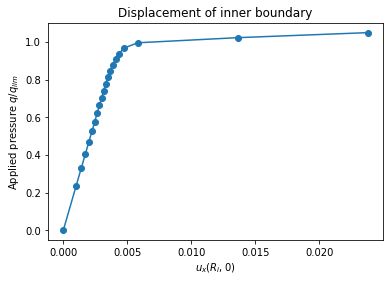

In [12]:
if len(points_on_proc) > 0:
    plt.plot(results[:, 0], results[:, 1], "-o")
    plt.title("Displacement of inner boundary")
    plt.xlabel(r"$u_x(R_i,0)$")
    plt.ylabel(r"Applied pressure $q/q_{lim}$")
    plt.savefig(f"displacement_rank{MPI.COMM_WORLD.rank:d}.png")
    plt.show()

## Miscellaneous: replacement of manual Newton solver by SNES

There is another interesting way of implementing the classical approach. Instead of manual  calculation of the derivative of the residue between internal and external forces (i.e. the calculation of the consistent tangent matrix), some methods approximating the derivative numerically can be applied. For example, the `ufl.derivative` function gives a derivative approximation of an input UFL-expression, which in this case represents the forces residue. Therefore it is required to change the original weak formulation in the following way

$$
\begin{align*}
    &\text{Find } \underline{u}_{n+1} \text{ such that}\\
    &R = \int\limits_\Omega \underline{\underline{\sigma}}_{n+1}:\underline{\underline{\varepsilon}}(\underline{v}) d\Omega - \underline{F}_{n+1}^\text{ext}(\underline{v}) = \int\limits_\Omega \left( \underline{\underline{\sigma}}_{n} + \mathbf{C} : (\Delta\underline{\underline{\varepsilon}} - \Delta\underline{\underline{\varepsilon}}^p) \right) : \underline{\underline{\varepsilon}}(\underline{v})d\Omega - \underline{F}_{n+1}^\text{ext}(\underline{v}) = 0,
\end{align*}
$$

where $\underline{\underline{\sigma}}_{n+1} = \underline{\underline{\sigma}}(\underline{u})_{n+1}$, $\underline{u}_{n+1} = \underline{u}_n + \Delta\underline{u}$, $\Delta\underline{\underline{\varepsilon}} = \underline{\underline{\varepsilon}}(\Delta\underline{u})$ and the plastic deformation increment $\Delta\underline{\underline{\varepsilon}}^p = \underline{\underline{\varepsilon}}^p(\Delta\underline{u})$ actually contains a return-mapping algorithm "inside" of its expression. Explicitly it can be written
out as follows

$$
\Delta\underline{\underline{\varepsilon}}^p =
\begin{cases}
    \Delta p \left(\frac{3}{2}\frac{\underline{\underline{s}}_{n+1}^\text{elas}}{\sigma_{n+1}^\text{elas,eq}} \right), \quad \text{ if } f(\underline{\underline{\sigma}}_{n+1}^\text{elas}, p_{n+1}) > 0\\
    0, \quad \text{otherwise.}
\end{cases}
$$

While solving the original problem, the described in this section of the tutorial implementation of the classical approach natively applies the return-mapping algorithm, as the correction is embedded into the weak formulation in the form of strain increment $\Delta\underline{\underline{\varepsilon}}^p$. That is why there is no need to calculate the consistent tangent matrix that was required for the linearization of the weak formulation. This means that it is not necessary to interpolate expressions taking part in the return-mapping algorithm on each iteration of the Newton method, so this implementation is faster than the previous one. However, the interpolation still has to be performed, at least to update the values of the stress vector and the cumulative plastic strain after. 

It is worth noticing that such an implementation can be **applicable only if** the return-mapping procedure can be performed **analytically**, as it requires an explicit expression of the plastic strain increment $\Delta\underline{\underline{\varepsilon}}^p$. On the contrary, although the implementation of the classical approach using manual Newton method was introduced for an “analytical” return-mapping procedure, it can be extended to a more general case, where a plasticity model is based on a nonsmooth yield criterion.

### Defining useful UFL expressions 

In [13]:
def proj_sig_SNES(Du, old_sig, old_p):
    sig_n = as_3D_tensor(old_sig)
    sig_elas = sig_n + sigma(eps(Du))
    s = ufl.dev(sig_elas)
    sig_eq = ufl.sqrt(3/2.*ufl.inner(s, s))
    f_elas = sig_eq - sig0 - H*old_p
    # dp = ufl.conditional(f_elas > 0, f_elas/(3*mu+H), 0)
    dp = ppos(f_elas)/(3*mu_ + H)
    beta = ufl.conditional(f_elas > 0, 3*mu_*dp/sig_eq, 0)
    new_sig = sig_elas-beta*s
    return ufl.as_vector([new_sig[0, 0], new_sig[1, 1], new_sig[2, 2], new_sig[0, 1]]), \
           dp

def deps_p(deps, old_sig, old_p):
    sig_n = as_3D_tensor(old_sig)
    sig_elas = sig_n + sigma(deps)
    s = ufl.dev(sig_elas)
    sig_eq = ufl.sqrt(3/2.*ufl.inner(s, s))
    f_elas = sig_eq - sig0 - H*old_p
    dp_sig_eq = ufl.conditional(f_elas > 0, f_elas/(3*mu_ + H)/sig_eq, 0) # Note: sig_eq is equal to 0 on the first iteration
    # dp = ppos(f_elas)/(3*mu+H) # this approach doesn't work with ufl.derivate
    return 3./2. * dp_sig_eq * s 

### Numerical parameters of SNES solvers

In [14]:
petsc_options_SNES = {
    "snes_type": "vinewtonrsls",
    "snes_linesearch_type": "basic",
    "ksp_type": "preonly",
    "pc_type": "lu",
    "pc_factor_mat_solver_type": "mumps",
    "snes_atol": 1.0e-08,
    "snes_rtol": 1.0e-08,
    "snes_stol": 0.0,
    "snes_max_it": 500,
    "snes_monitor": "",
    # "snes_monitor_cancel": "",
}

petsc_options_SNESQN = {
    "snes_type": "qn",
    "snes_qn_type": "lbfgs", #<lbfgs, broyden, badbroyden>
    "snes_qn_m": 100,
    "snes_qn_scale_type": "jacobian", #<diagonal,none,scalar,jacobian> 	
    "snes_qn_restart_type": "none", 
    "pc_type": "cholesky", #<cholesky, hypre, gamg,sor ; asm, lu, ...>
    "snes_linesearch_type": "basic",
    "ksp_type": "preonly",
    "pc_factor_mat_solver_type": "mumps",
    "snes_atol": 1.0e-08,
    "snes_rtol": 1.0e-08,
    "snes_stol": 0.0,
    "snes_max_it": 500,
    # "snes_monitor": "",
    "snes_monitor_cancel": "",
}

In [15]:
residual = ufl.inner(as_3D_tensor(sig) + sigma(eps(Du) - deps_p(eps(Du), sig, p)), eps(u_))*dx - F_ext(u_)

J = ufl.derivative(ufl.inner(sigma(eps(Du) - deps_p(eps(Du), sig, p)), eps(u_))*dx, Du, v_)
my_problem = pf.SNESProblem(residual, Du, J, bcs, petsc_options=petsc_options_SNES)

# In the case of the quasi-Newton method we have to provide an initial Jacobian value to the solver.
# On the first loading step there is an elastic response only, so we always know this initial value and it is proportional to an elastic stiffness matrix.
# Uncomment lines below to test the quasi-Newton method.

# J_QN = ufl.derivative(ufl.inner(sigma(eps(Du)), eps(u_))*dx, Du, v_)
# my_problem = pf.SNESProblem(residual, Du, J_QN, bcs, petsc_options=petsc_options_SNESQN)

In [16]:
results_SNES = np.zeros((Nincr+1, 2))

sig.vector.set(0.0)
p.vector.set(0.0)
u.vector.set(0.0)

sig_, dp_ = proj_sig_SNES(Du, sig, p)

start = time.time()

for (i, t) in enumerate(load_steps):
    loading.value = t * q_lim

    Du.x.array[:] = 0

    nits = my_problem.solve()

    if MPI.COMM_WORLD.rank == 0:
        print(f"\n Increment: {str(i+1)}, load = {t * q_lim}")
   
    fs.interpolate_quadrature(sig_, sig)
    fs.interpolate_quadrature(dp_, dp)
    
    p.vector.axpy(1, dp.vector)
    p.x.scatter_forward()
    u.vector.axpy(1, Du.vector) # u = u + 1*Du
    u.x.scatter_forward()

    if len(points_on_proc) > 0:
        results_SNES[i+1, :] = (u.eval(points_on_proc, cells)[0], t)

print(f'rank#{MPI.COMM_WORLD.rank}: Time = {time.time() - start:.3f} (s)')

  0 SNES Function norm 2.853682384400e+00 
  1 SNES Function norm 2.950426966767e-12 

 Increment: 1, load = 17.7621446711497
  0 SNES Function norm 1.182033946324e+00 
  1 SNES Function norm 1.231209664176e-12 

 Increment: 2, load = 25.119465890772904
  0 SNES Function norm 9.070065477214e-01 
  1 SNES Function norm 9.503397572437e-13 

 Increment: 3, load = 30.764937021820067
  0 SNES Function norm 7.646418903549e-01 
  1 SNES Function norm 7.972872164343e-13 

 Increment: 4, load = 35.5242893422994
  0 SNES Function norm 6.736630289121e-01 
  1 SNES Function norm 7.066891452507e-13 

 Increment: 5, load = 39.717362910876375
  0 SNES Function norm 6.090379320367e-01 
  1 SNES Function norm 6.351226235359e-13 

 Increment: 6, load = 43.50819118181207
  0 SNES Function norm 5.600681801394e-01 
  1 SNES Function norm 5.735521577538e-13 

 Increment: 7, load = 46.99421755101324
  0 SNES Function norm 5.212987515591e-01 
  1 SNES Function norm 5.565172114482e-13 

 Increment: 8, load = 5

### Post-processing 

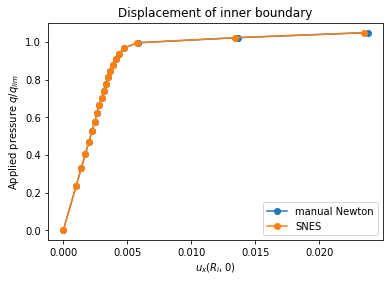

In [17]:
if len(points_on_proc) > 0:
    plt.plot(results[:, 0], results[:, 1], "-o", label="manual Newton")
    plt.plot(results_SNES[:, 0], results_SNES[:, 1], "-o", label="SNES")
    plt.title("Displacement of inner boundary")
    plt.xlabel(r"$u_x(R_i,0)$")
    plt.ylabel(r"Applied pressure $q/q_{lim}$")
    plt.legend()
    plt.savefig(f"displacement_rank{MPI.COMM_WORLD.rank:d}.png")
    plt.show()